In [213]:
from ml_model import nn
from numerical_model import lorenz96

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

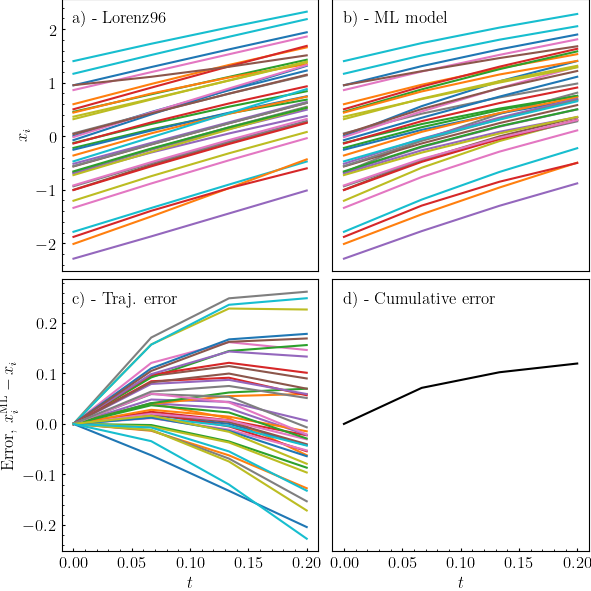

In [214]:
# Time step for the ML model; use the same for the numerical integration
# total time 
t_tot = .2
n_steps = 4
dt = t_tot / n_steps

# Generate a random state
np.random.seed(270)
x0 = np.random.randn(40)

x = x0
x_ml = np.zeros((n_steps, 40))
x_ml[0] = x0
for i in range(1, n_steps):
    x = nn._smodel.predict(x.reshape((1, 40, 1)))[0, :, 0]
    x_ml[i] = x

x_phys = solve_ivp(lorenz96, [0, n_steps*dt], x0, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T

time = np.linspace(0, dt * n_steps, x_phys.shape[0])
# plot physical trajectory, nn trajectory and error with time on the x-axis
# fig, ax = plt.subplots(2,2, figsize=(6,6))
# ax[0,0].plot(time, x_phys)
# ax[0,0].set_title("True Model Run (40 vars)")
# ax[0,1].plot(time, x_ml)
# ax[0,1].set_title("ML Model Run (40 vars)")
# ax[1,0].plot(time, x_ml-x_phys)
# ax[1,0].set_title("Trajectory-wise error")

# ax[1,1].plot(time, np.sqrt(((x_ml - x_phys)**2).mean(axis=1)))
# ax[1,1].set_title("Avg Error across 40 components")

fig = plt.figure(layout="constrained", figsize=(6, 6))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.00, hspace=0.00)

# Plot reference solution
ax = fig.add_subplot(gs[0, 0])
ax.plot(time, x_phys)
plt.xticks([], [])
plt.ylabel(r'$x_i$')
ylim = ax.get_ylim()
plt.text(0.04, 0.96, 'a) - Lorenz96', transform=ax.transAxes, ha='left', va='top', zorder=100, color='k')

# Plot ML solution
ax = fig.add_subplot(gs[0, 1])
ax.plot(time, x_ml)
plt.yticks([], [])
plt.xticks([], [])
ax.set_ylim(ylim)
plt.text(0.04, 0.96, 'b) - ML model', transform=ax.transAxes, ha='left', va='top', zorder=100, color='k')

# Plot trajectory-wise error
ax = fig.add_subplot(gs[1, 0])
ax.plot(time, x_ml - x_phys)
plt.ylabel(r'Error, $x^\mathrm{ML}_i - x_i$')
plt.xlabel(r'$t$')
ylim = ax.get_ylim()
plt.text(0.04, 0.96, 'c) - Traj. error', transform=ax.transAxes, ha='left', va='top', zorder=100, color='k')

# Plot average error
ax = fig.add_subplot(gs[1, 1])
ax.plot(time, np.sqrt(((x_ml - x_phys)**2).mean(axis=1)), color='k')
plt.yticks([], [])
plt.xlabel(r'$t$')
ax.set_ylim(ylim)
plt.text(0.04, 0.96, 'd) - Cumulative error', transform=ax.transAxes, ha='left', va='top', zorder=100, color='k')

plt.savefig('lorenz96_true_vs_ml.pdf', dpi=300, bbox_inches='tight')

In [215]:
y = x_phys[-1,:] # extract values we want to fit with EKI

## Notation
The `Lorenz96` model, named after it's founder, Ed Lorenz, in 1996, is a dynamical system that mimics the state of the atmosphere at 40 equally spaced points around a latitude band. For the earth, the high rotation rate and thin atmosphere result in a system where the dominant direction of motion is East-West, not North-South, and thus the one-dimensional approximation is perhaps to first order somewhat reasonable.  Examining the 40 ordinary differential equations, 
$$ \frac{dx_i}{dt} = (x_{i+1}- x_{i-2})\cdot x_{i-1} - x_i + F$$ 
We see three terms added together. The first is an asymetric interaction term that evolves the state at the current location based on its neighbors; this models the advective dynamics of the atmosphere, while the other two terms, $-x_i$ and $F$ correspond to forcing term. Here we can imagine that $-x_i$ is a dissipation term, e.g., outgoing longwave radiation, while $+F$, is forcing, e.g., solar insolation, that is added to the system. The value $F=8$ is used in our project because it has been shown to generate chaotic behavior.

### Motivation 
Let's see if we can solve this with backwards euler!?

In [216]:
def lorenz96(t, x, F=8):
    """Lorenz 96 model with constant forcing"""
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        dxdt[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return dxdt

def integrate_backward_euler(lorenz_func, t_span, x0, F=8, dt=0.00001):
    """Integrate the given function backwards in time using Euler steps"""
    t_points = np.arange(t_span[0], t_span[1], -dt)
    n_steps = len(t_points)
    n_dim = len(x0)
    x = np.zeros((n_steps, n_dim))
    x[0] = x0
    
    for i in range(1, n_steps):
        dxdt = lorenz_func(t_points[i], x[i - 1], F)
        x[i] = x[i - 1] - dxdt * dt
        
    return t_points, x

# Define parameters
t_span = [0, -.200001]  # Integrate backwards in time 

# Integrate backwards in time using Euler steps
t_points, x = integrate_backward_euler(lorenz96, t_span, y+np.random.randn(40)*1)

print("Integration successful.")
print("Time points:", t_points)
print("Solution shape:", x.shape)


Integration successful.
Time points: [ 0.0000e+00 -1.0000e-05 -2.0000e-05 ... -1.9998e-01 -1.9999e-01
 -2.0000e-01]
Solution shape: (20001, 40)


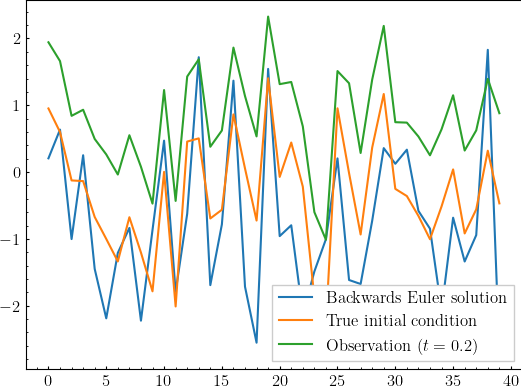

In [217]:
plt.plot(x[-1], label="Backwards Euler solution")
plt.plot(x0, label="True initial condition")
plt.plot(y, label="Observation ($t=0.2$)")
plt.legend(framealpha=1)
plt.savefig('lorenz96_backwards_euler.pdf', dpi=300, bbox_inches='tight')

In [218]:
np.linalg.norm(x[-1] - x0)

6.371925688479577

## EKI
This motivates the following update rule for an ensemble of particles: 
\begin{align}
    x_0^{i+1} &= x_0^i + C^{x_0, \mathcal{G}}(\Gamma_y + C^{\mathcal{G}, \mathcal{G}})^{-1}\cdot (y-\mathcal{G}(x_0^i))
\end{align}
where the true covariances are approximated with the sample covariances across the ensemble (see \citet{iglesias13} and class notes for the derivation): 
\begin{align}
    C^{x_0, \mathcal{G}} &= \frac{1}{J} \sum_{j=1}^J \left([x_0^j - \bar{x_0}]\cdot [\mathcal{G}(x_0^j)-\overline{\mathcal{G}(x_0)}]^T\right) \\
    C^{\mathcal{G}, \mathcal{G}} &= \frac{1}{J}\sum_{j=1}^J \left([\mathcal{G}(x_0^j)-\overline{\mathcal{G}(x_0)}] \cdot [\mathcal{G}(x_0^j)-\overline{\mathcal{G}(x_0)}]^T\right)
\end{align}
where 
\begin{align}
    \overline{\mathcal{G}(x_0)} &= \frac{1}{J}\sum_{j=1}^J \mathcal{G}(x_0^j) \\
    \bar{x_0} &= \frac{1}{J}\sum_{j=1}^J x_0^j
\end{align}
These covariance matrices together with the noise matrix define the Kalman gain, $K=C^{x_0, \mathcal{G}}(\Gamma_y + C^{\mathcal{G}, \mathcal{G}})^{-1}$ which tells us how the ensemble should move. This method converges exactly and in one iteration for forward models that are linear, e.g. $\mathcal{G}(x_0) = Gx_0$, however takes multiple iterations for good convergence for non-linear forward models. While there are no guarantees for convergence of this method for non-linear forward maps, in practice it works quite well. 

### MCMC writeup
To explore the distribution of $x_0$ that could have given rise to our observations $y$, we use Metropolis-Hastings 

In [219]:
J = 50 # choose number of ensemble members
theta0 = np.random.randn(x0.shape[0], J) # generate initial ensemble of estimates

In [220]:
# map the theta0 ensemble through the numerical model 
# def forward_model(theta, noise=0.01):
#     theta_update = np.zeros_like(theta)
#     for i in range(J):
#         val_noise = np.random.randn(theta.shape[0]) * noise
#         theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:] + val_noise
#     return theta_update
def forward_model(theta):
    theta_update = np.zeros_like(theta)
    for i in range(J):
        theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]
    return theta_update 

theta = forward_model(theta0)

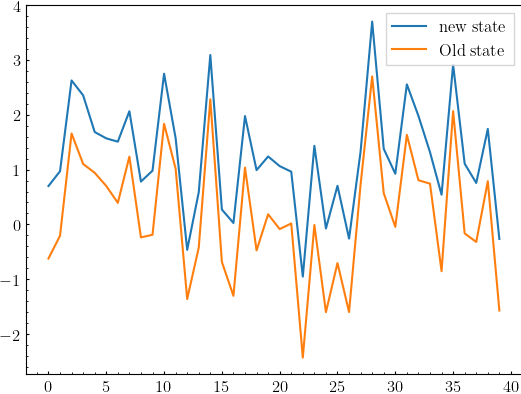

In [221]:
# example of what one forward model step looks like
plt.plot(theta[:,0], label = "new state")
plt.plot(theta0[:,0], label= "Old state")
plt.legend()

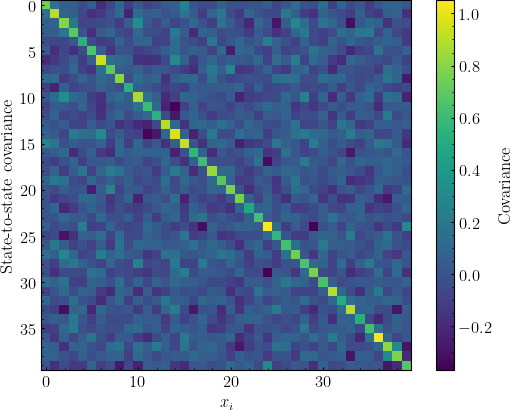

In [222]:

def CGG(Gtheta):
    return np.cov(Gtheta, bias=True)

def CTG(theta, Gtheta):
    """Calculate the cross covariance of the previous state and the next state. 
    Note that for early steps there won't be much correlation"""
    
    num_states = theta.shape[0]
    # https://stackoverflow.com/questions/45134122/numpy-cov-returns-unexpected-output
    return np.cov(np.transpose(theta), np.transpose(Gtheta), bias=True, rowvar=False)[:num_states, num_states:]

plt.imshow(CTG(forward_model(theta0), theta))
plt.xlabel('$x_i$')
plt.ylabel('State-to-state covariance')
cbar = plt.colorbar()
cbar.set_label('Covariance')

In [223]:
# we then define our EKI update step
def EKI_update(theta, Gtheta, y, Gamma, J=J):
    """Update the ensemble of states using the EKI update formula"""
    update = CTG(theta, Gtheta) @ np.linalg.inv(Gamma + CGG(Gtheta)) @ (np.repeat(y, J).reshape(40, J) - Gtheta)
    
    return theta + update, np.linalg.norm(update)
#EKI_update(theta0, theta, y, np.eye(40) * 0.01)

In [224]:
# now we can run the EKI algorithm
iters = 10*40
next_theta = theta0
for i in range(iters):
    next_theta, norm = EKI_update(next_theta, forward_model(next_theta), y, np.eye(40) * .1)
    if i % 20 == 0:
        print(i, norm)
    if norm < 1e-4:
        print(i, norm)
        break

0 52.070798865982
20 0.13293596047378914
40 0.05418001897264307
60 0.03130130800402519
80 0.021023330273465524
100 0.015368240682668767
120 0.011867280927276375
140 0.009523633862772168
160 0.007863084323960434
180 0.006635355478452271
200 0.005697201947321681
220 0.004961220143135132
240 0.004371226080409772
260 0.003889633239979212
280 0.003490490134127524
300 0.0031552868887335076
320 0.002870535792836197
340 0.0026262025446585997
360 0.002414681611323496
380 0.0022301155660739342


In [225]:
print(np.linalg.norm(theta0.mean(axis=1) - x0))
np.linalg.norm(next_theta.mean(axis=1) - x0)

5.789815819462407


0.22415533366796966

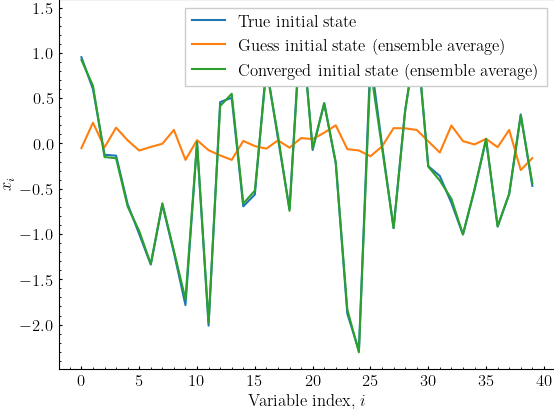

In [226]:
plt.plot(x0, color='k', label="True initial state")
plt.plot(theta0.mean(axis=1), color='r', linestyle='-.', label="Guess initial state (ensemble average)")
plt.plot(next_theta.mean(axis=1), color='b', linestyle='--', label="Recovered initial state (ensemble average)")
plt.xlabel("Variable index, $i$")
plt.ylabel(r"$x_i$")
plt.legend(framealpha=1)
plt.savefig('lorenz96_eki.pdf', dpi=300, bbox_inches='tight')

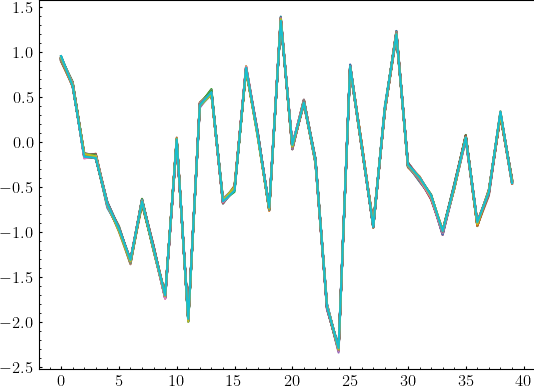

In [227]:
plt.plot(next_theta);

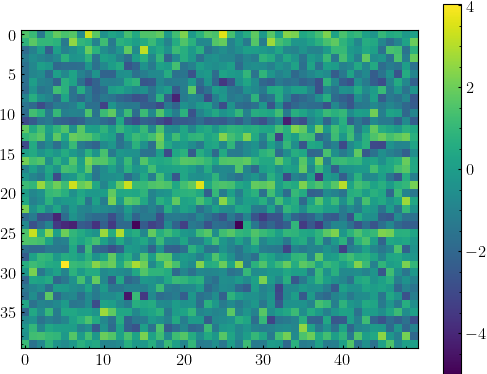

In [228]:
plt.imshow(next_theta-theta0)
plt.colorbar()

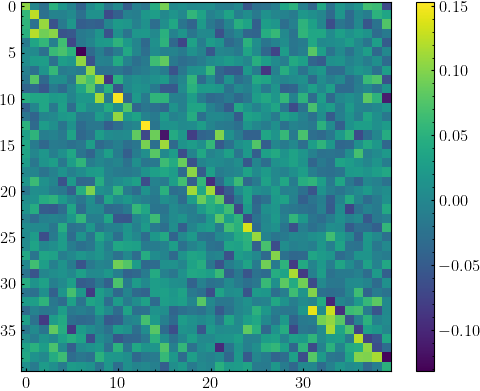

In [229]:
plt.imshow(CTG(theta0, theta) -CGG(theta))
plt.colorbar()

## MCMC 
We are asked to draw samples from the posterior using MCMC. A general posterior looks like:
$$ \pi^y(u) = \frac{1}{Z} \nu(y-\mathcal{G}(u))\rho(u) $$
In our setting the posterior, $\pi^y(u)$, is the posterior of the \textit{initial} condition given an observation, $$\nu(y-\mathcal{G}(u)) \propto \exp\left(-\frac{1}{2}|y-\mathcal{G}(u)|_\Gamma^2 \right)$$ is the likihood function of the initial condition given the observations, $y$, and $\rho(u)$ is the multivariate normal prior we set for the initial condition (which is the same as what the true distribution was drawn from). To implement this we will use the Metropolis-Hastings Algorithm with the following distributions:
Initial sample:
$$ u^{(0)} \sim \pi_0; \;\;\; \pi_0 = \mathcal{MVN}(\vec{0}, I_{40})$$
(Note we could use $\pi_0=\mathcal{MVN}(\text{mean converged EKI}, \text{cov converged EKI})$ if current proposal fails to converge)
$$v^\star \sim q(u^{(n)},v) = \mathcal{MVN}(u^{(n)}-v, \mathbb{I}_{40}) \propto \exp \left[-\frac{1}{2} (u^{(n)}-v)^T\mathbb{I}_{40}(u^{(n)}-v)\right]$$ 

### Uninformed Prior
This ended up not being successful because the acceptance probabilities were too low starting far from the true solution. 

In [230]:
def G(u):
    """Forward model for the Lorenz96 system."""
    return solve_ivp(lorenz96, [0, n_steps*dt], u, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]

def propnu(u, y=y, noise=0.1):
    return np.exp(-0.5 * np.transpose(y - G(u)) @ (np.eye(40) * noise) @ np.linalg.inv(np.eye(40) * noise) @ (y - G(u)))

def q(u):
    return np.random.multivariate_normal(u, np.eye(40))

def propq(u,v):
    return np.exp(-0.5 * np.transpose(u - v) @ np.linalg.inv(np.eye(40)) @ (u - v))

def proprho(u):
    return np.exp(-0.5 * np.transpose(u) @ np.linalg.inv(np.eye(40)) @ u)

def a(u, v):
    return min(1, propnu(v, y) * propq(v,u) * proprho(v) / \
               (propnu(u, y) * propq(u,v) * proprho(u)))

#a(theta0[:,0], theta0[:,9])

In [231]:
# with our functions defined we can now run the MCMC algorithm
n_samples = 10000
samples = np.zeros((n_samples, 40))
samples[0] = theta0[:,0] # random initial guess (just reusing from before)
probs = np.zeros(n_samples)
for i in range(1, n_samples):
    u = samples[i-1]
    v = q(u)
    accept_prob = a(u, v)
    probs[i] = accept_prob
    if np.random.rand() < accept_prob:
        print("Accepted!")
        samples[i] = v
    else:
        samples[i] = u

Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!
Accepted!


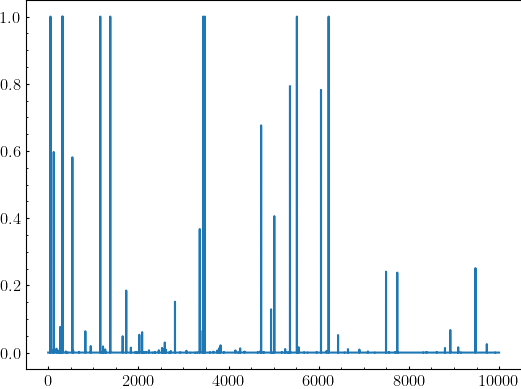

In [232]:
plt.plot(probs)

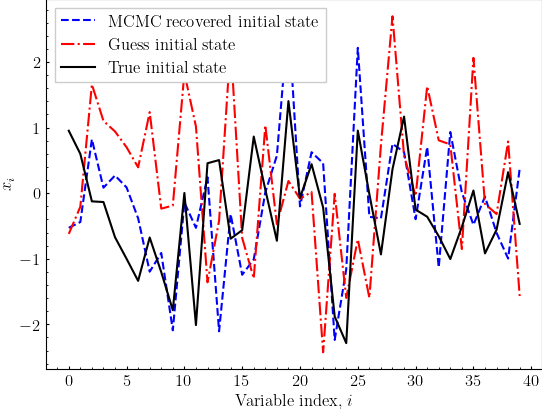

In [236]:
plt.plot(x0, color='k', label='True initial state')
plt.plot(theta0[:,0], color='r', linestyle='-.', label='Guess initial state')
plt.plot(np.transpose(samples[-1,]), color='b', linestyle='--', label='Recovered initial state')
plt.xlabel("Variable index, $i$")
plt.ylabel(r"$x_i$")
plt.legend(framealpha=1)
plt.savefig('lorenz96_mcmc.pdf', dpi=300, bbox_inches='tight')

## Let's inform our MCMC with the results from the EKI
Use the mean and covariance from final eki result (maybe we'll need to scale up the covariance matrix so it doesn't collapse). These will become both our initial distribution and inform the sampler variance \texttt{q(u)}

In [199]:
# calculate the mean and covariance matrix of EKI result 
mean_eki = next_theta.mean(axis=1)
cov_eki = np.cov(next_theta, bias=True)
np.linalg.cond(cov_eki) # well conditioned

2.6156166574146082

Text(0.5, 1.0, 'Scaled EKI Coviariance Matrix')

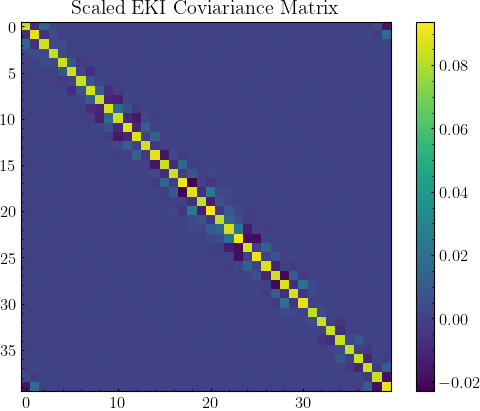

In [200]:
plt.imshow(cov_eki * 500) # cool to see that only local correlations exist
plt.colorbar()
plt.title("Scaled EKI Coviariance Matrix")

In [201]:
# update q(u) to use the covariance matrix of the EKI result
scale = 500
def q(u):
    return np.random.multivariate_normal(u, cov_eki * scale)
print(f"Matrix Norm: {np.linalg.norm(cov_eki * scale)}")


# with our functions defined we can now run the MCMC algorithm
n_samples = 1000
samples = np.zeros((n_samples, 40))

# update initial guess to use the mean of the eki result 
samples[0] = mean_eki

# run Metropolis Hastings
probs, accepted = np.zeros(n_samples), np.zeros(n_samples)
for i in range(1, n_samples):
    u = samples[i-1]
    v = q(u)
    accept_prob = a(u, v)
    probs[i] = accept_prob
    if np.random.rand() < accept_prob:
        accepted[i] = 1
        samples[i] = v
    else:
        samples[i] = u
print(f"Acceptance rate: {accepted.mean()}")

Matrix Norm: 0.5593193119861063
Acceptance rate: 0.219


Text(0.5, 1.0, 'EKI Informed MCMC Sampling of Lorenz96 System (cov-upweighting by 100)')

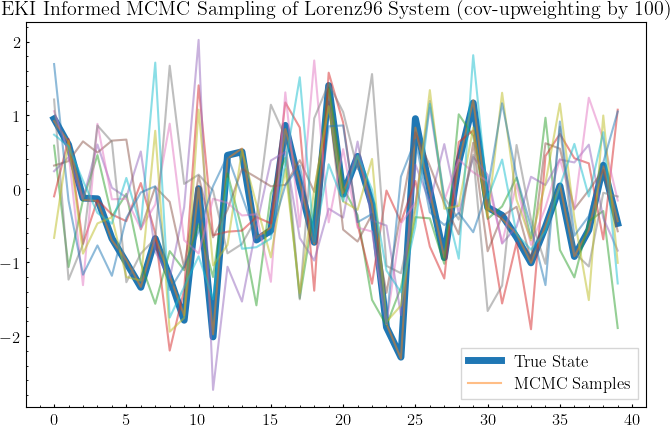

In [202]:
plt.figure(figsize=(8,5))
plt.plot(x0, linewidth=5)
plt.plot(np.transpose(samples[::100]), alpha=.5) # get every 1000th sample to reduce correlation
plt.legend(["True State", "MCMC Samples"])
plt.title("EKI Informed MCMC Sampling of Lorenz96 System (cov-upweighting by 100)")

### Correlation Assessment
Assess how frequently we should subsample by looking at the correlation

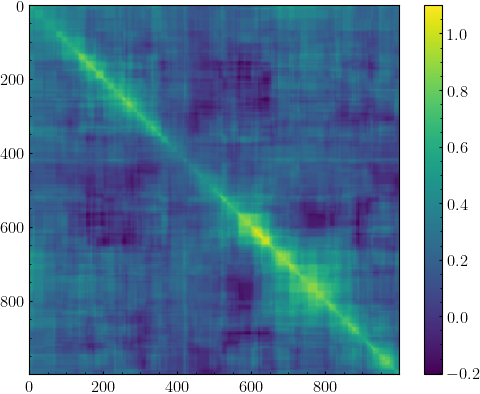

In [203]:
plt.imshow(np.cov(samples))
plt.colorbar()

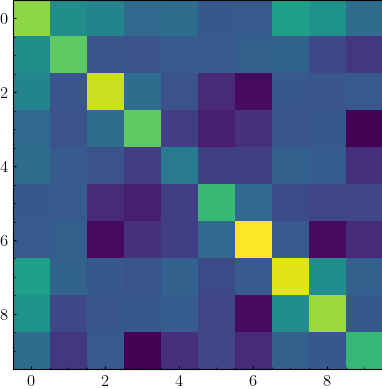

In [204]:
plt.imshow(np.cov(samples[::100]))

In [205]:
np.correlate(samples[:,0], samples[:,0])

array([653.44408515])

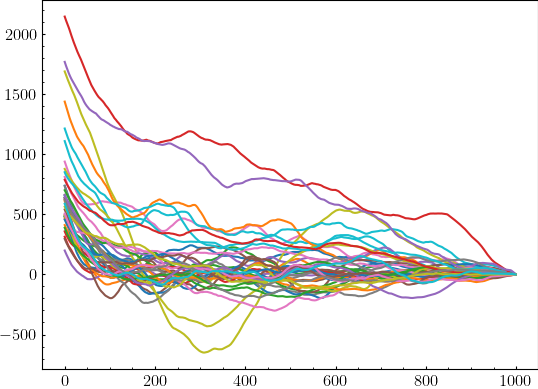

In [206]:
ndim = 1
for i in range(40):
    plt.plot(np.correlate(samples[:,i], samples[:,i], mode='full')[-n_samples:])


In [207]:
def autocorrelation(x):
    """Calculate the autocorrelation of the time series x."""
    n = len(x)
    variance = np.var(x)
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[-n:]
    result = r / (variance * (np.arange(n, 0, -1)))
    return result

def integrated_autocorrelation_time(autocorr):
    """Calculate the integrated autocorrelation time from the autocorrelation function."""
    return 1 + 2 * np.sum(autocorr[1:])

def autocorrelation_time(samples):
    """Calculate the autocorrelation time for each dimension in the MCMC samples."""
    n_samples, n_dim = samples.shape
    autocorr_times = np.zeros(n_dim)
    
    for d in range(n_dim):
        autocorr = autocorrelation(samples[:, d])
        # Truncate the autocorrelation function where it first becomes negative
        autocorr = autocorr[autocorr > 0]
        autocorr_times[d] = integrated_autocorrelation_time(autocorr)
        
    return autocorr_times

# Calculate autocorrelation times for each dimension
autocorr_times = autocorrelation_time(samples)

# Print the autocorrelation times
print("Autocorrelation times for each dimension:", autocorr_times)

# Average autocorrelation time over all dimensions
average_autocorr_time = np.mean(autocorr_times)
print("Average autocorrelation time:", average_autocorr_time)


Autocorrelation times for each dimension: [192.46051885 244.57616356 175.18737406 187.15777748  91.05673616
 396.82854148 173.70234255 162.35530315 305.26175773 198.64928965
 243.71793551 188.41728448 331.64269923 197.44309606 195.79008709
 266.03836797 169.16801397 227.0098715  310.18670791 231.8562244
 324.22447417 142.13214846 179.57961178 273.48170147 236.82475244
 172.64132628 490.34685495 508.54268529 359.6016019  192.05492198
 223.62690231 149.71297232 243.63102348 186.16453374 216.49804951
 231.50408106 125.97468877 287.24084583 268.69304592 187.03651859]
Average autocorrelation time: 237.2004708252047


## Update EKI observation map for partial observations

In [208]:
# generate observations 
t_tot = .2
n_steps = 4
dt = t_tot / n_steps

# Generate a random state
np.random.seed(270)
x0 = np.random.randn(40)

x = x0
x_ml = np.zeros((n_steps, 40))
x_ml[0] = x0
for i in range(1, n_steps):
    x = nn._smodel.predict(x.reshape((1, 40, 1)))[0, :, 0]
    x_ml[i] = x

x_phys = solve_ivp(lorenz96, [0, n_steps*dt], x0, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T

y = x_phys[-1,:] # extract values we want to fit with EKI
y_ml = x_ml[-1,:]

In [209]:
# partial observations, these are what we get to tune our model to
def H(y, it=2):
    return y[::it]

y_obs = H(y)
y_ml_obs = H(y_ml)

In [210]:
# as before our samples are drawn from a 40-dimensional initial condition
J = 50 # choose number of ensemble members
theta0 = np.random.randn(x0.shape[0], J) # generate initial ensemble of estimates

def forward_model(theta, observation_map = H):
    """Lorenz 96 Forward Model"""
    theta_update = np.zeros_like(theta)
    for i in range(J):
        theta_update[:,i] = solve_ivp(lorenz96, [0, n_steps*dt], theta[:,i], t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:]
    # note that this time we apply the observation map to the output
    return observation_map(theta_update)

def CGG(Gtheta):
    """Returns the covariance matrix of the forward ensemble states"""
    return np.cov(Gtheta, bias=True)

def CTG(theta, Gtheta):
    """Calculate the cross covariance of the previous state and the next state. 
    Note that for early steps there won't be much correlation"""
    
    first_dim, second_dim = theta.shape[0], Gtheta.shape[0]
    # https://stackoverflow.com/questions/45134122/numpy-cov-returns-unexpected-output
    return np.cov(np.transpose(theta), np.transpose(Gtheta), bias=True, rowvar=False)[:first_dim, -second_dim:]

def EKI_update(theta, Gtheta, y, Gamma, J=J):
    """Update the ensemble of states using the EKI update formula"""
    update = CTG(theta, Gtheta) @ np.linalg.inv(Gamma + CGG(Gtheta)) @ (np.repeat(y, J).reshape(y.shape[0], J) - Gtheta)
    
    return theta + update, np.linalg.norm(update)

In [211]:
max_iter = 10*40
next_theta = theta0
for i in range(max_iter):
    next_theta, norm = EKI_update(next_theta, forward_model(next_theta), y_obs, np.eye(y_obs.shape[0]) * 1)
    if i % 20 == 0:
        print(i, norm)
    if norm < 1e-2:
        print(i, norm)
        break

0 21.984531745302363
20 0.30920564453819827
40 0.13831934947689034
60 0.09228067073791517
80 0.0732114907779764
100 0.0636596012206435
120 0.058407028178689424
140 0.055300314385141935
160 0.05337601837394235
180 0.052049593860147424


KeyboardInterrupt: 

In [ ]:
print(np.linalg.norm(theta0.mean(axis=1) - x0))
np.linalg.norm(next_theta.mean(axis=1) - x0)

6.016941273595244


6.091880006752788

In [ ]:
theta0[::2].shape

(20, 50)

In [ ]:
# does converge well on the locations we show EKI!
print(np.linalg.norm(theta0[::2].mean(axis=1) - x0[::2]))
np.linalg.norm(next_theta[::2].mean(axis=1) - x0[::2])

3.7228183581409864


0.6973337241857727

Text(0.5, 1.0, 'EKI Convergence for Partial Observations')

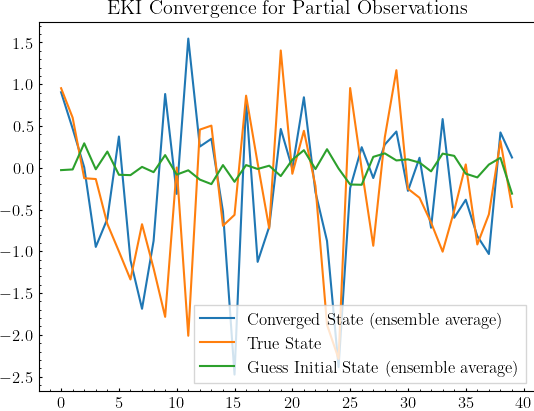

In [ ]:
plt.plot(next_theta.mean(axis=1), label="Converged State (ensemble average)")
plt.plot(x0,label="True State")
plt.plot(theta0.mean(axis=1), label="Guess Initial State (ensemble average)")
plt.legend()
plt.title("EKI Convergence for Partial Observations")

### Sample from the posterior using MCMC
Again, we'll use the results from the EKI model

In [ ]:
mean_eki = next_theta.mean(axis=1)
cov_eki = np.cov(next_theta, bias=True)

Text(0.5, 1.0, 'EKI Coviariance Matrix')

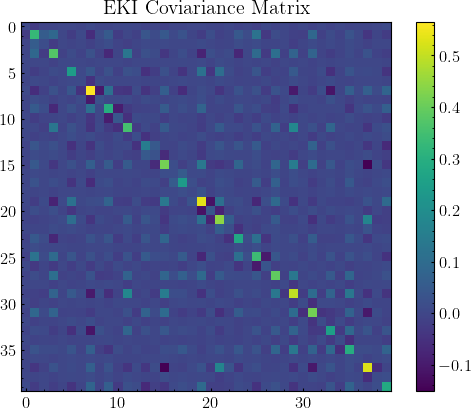

In [ ]:
plt.imshow(cov_eki ) # much stranger covariance matrix!
plt.colorbar()
plt.title("EKI Coviariance Matrix")

In [ ]:
def G(u, observation_map = H):
    """Forward model for the Lorenz96 system."""
    return observation_map(solve_ivp(lorenz96, [0, n_steps*dt], u, t_eval=np.arange(0.0, n_steps*dt, dt)).y.T[-1,:])

def propnu(u, y=y, noise=0.1):
    return np.exp(-0.5 * np.transpose(y - G(u)) @ (np.eye(y.shape[0]) * noise) @ np.linalg.inv(np.eye(y.shape[0]) * noise) @ (y - G(u)))

def q(u, cov_eki=cov_eki, scale=500):
    """use the covariance matrix of the EKI result to generate a new proposal"""
    return np.random.multivariate_normal(u, cov_eki * scale)

def propq(u,v, y=y):
    return np.exp(-0.5 * np.transpose(u - v) @ np.linalg.inv(np.eye(40)) @ (u - v))

def proprho(u,y=y):
    return np.exp(-0.5 * np.transpose(u) @ np.linalg.inv(np.eye(40)) @ u)

def a(u, v, y=y):
    return min(1, propnu(v, y) * propq(v, u, y) * proprho(v, y) / \
               (propnu(u, y) * propq(u, v, y) * proprho(u, y)))

In [ ]:
tu = mean_eki
tv =q(tu)
propnu(tu, y_obs)
proprho(tu, y_obs)
a(tu, tv, y_obs)

/tmp/ipykernel_74581/1179860384.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return min(1, propnu(v, y) * propq(v, u, y) * proprho(v, y) / \


1

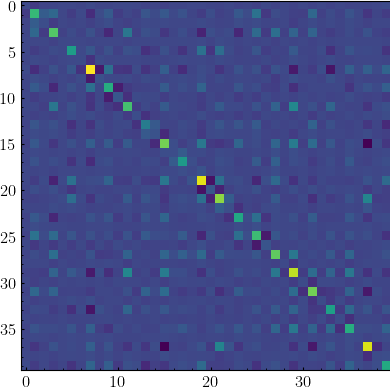

In [ ]:
plt.imshow(cov_eki) # high 

In [ ]:
np.linalg.cond(cov_eki) # very high condition number - we'll use a scaled identity matrix as covariance instead

3143.75039117596

In [ ]:
# with our functions defined we can now run the MCMC algorithm
n_samples = 1000
samples = np.zeros((n_samples, 40))

# update initial guess to use the mean of the eki result 
samples[0] = mean_eki

# run Metropolis Hastings
probs, accepted = np.zeros(n_samples), np.zeros(n_samples)
for i in range(1, n_samples):
    u = samples[i-1]
    # I tuned the chain acceptance probability by adjusting the covariance matrix
    v = q(u, np.eye(40)*.1, scale=1) 
    accept_prob = a(u, v, y_obs)
    probs[i] = accept_prob
    #print(accept_prob)
    if np.random.rand() < accept_prob:
        accepted[i] = 1
        samples[i] = v
    else:
        samples[i] = u
print(f"Acceptance rate: {accepted.mean()}")

Acceptance rate: 0.265


Text(0.5, 1.0, 'EKI Informed MCMC Sampling of Lorenz96 System with Partial Observations')

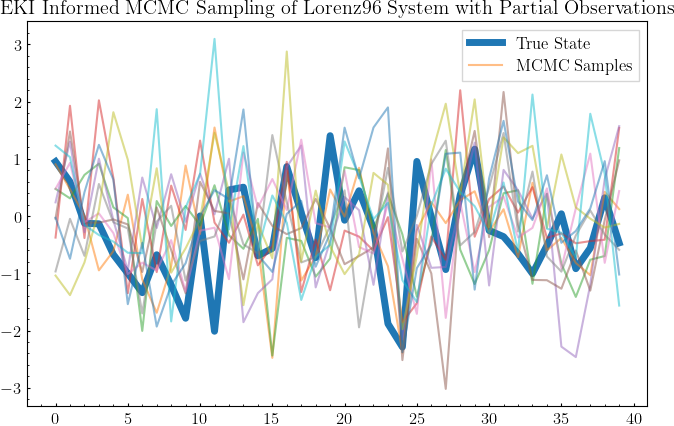

In [ ]:
# visualize samples
plt.figure(figsize=(8,5))
plt.plot(x0, linewidth=5)
plt.plot(np.transpose(samples[::100]), alpha=.5) # get every 1000th sample to reduce correlation
plt.legend(["True State", "MCMC Samples"])
plt.title("EKI Informed MCMC Sampling of Lorenz96 System with Partial Observations")

## Repeat with the ML Model